# Лабораторная работа 2
# Вариант 5
## Румянков Дмитрий Сергеевич
## 17 ВМв
## Методы классификации данных

1.	Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).
2.	Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции;
3.	Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)
4.	Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию);
5.	Выполните замену категориальных признаков; выберите и обоснуйте способ замены;
6.	Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации);
7.	Заполните пропущенные значения в данных;
8.	Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех». Оцените точность классификации для каждой их схем. Постройте кривые PR и ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества). Для линейного классификатора используйте регуляризацию. 
9.	Сравните кривые для классификаторов, указанных в задании, сделайте выводы.

#### Предсказать, выживет ли пасажир?

### Импорт

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from scipy import interp
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)
%config InlineBackend.figure_format = 'svg'
sns.set_style('whitegrid')

#### 1. Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных.

In [2]:
df = pd.read_csv(r'titanic3.csv', sep=';')
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29,0.0,0.0,24160,"211,3375",B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,"0,9167",1.0,2.0,113781,"151,5500",C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


| Column   | Description  |
|--------------|--------------|
| pclass | Класс |
| survived | Выжил или нет |
| name | Имя |
| sex | Пол пассажира |
| age | Возраст |
| sibsp| Число братьев/сестер/супругов на борту |
| parch| Число родителей/детей на борту|
| fare | Цена билета |
| ticket| Номер билета |
| cabin | Номер каюты | 
| embarked | Порт погрузки |
| boat | Номер шлюпки |
| body | Идентификационный номер тела |
| home.dest | Назначение |

In [4]:
list_to_drop = ['body', 'boat', 'name', 'cabin', 'ticket', 'home.dest']
df.drop(list_to_drop, axis=1, inplace=True)
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1.0,female,29,0.0,0.0,"211,3375",S
1,1.0,1.0,male,"0,9167",1.0,2.0,"151,5500",S
2,1.0,0.0,female,2,1.0,2.0,"151,5500",S
3,1.0,0.0,male,30,1.0,2.0,"151,5500",S
4,1.0,0.0,female,25,1.0,2.0,"151,5500",S


#### 2.Удалите дубликаты строк в наборе данных

In [5]:
df = df.drop_duplicates()
print('ds', df.shape)
df.count()

ds (1115, 8)


pclass      1114
survived    1114
sex         1114
age          974
sibsp       1114
parch       1114
fare        1113
embarked    1112
dtype: int64

#### 3.Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)

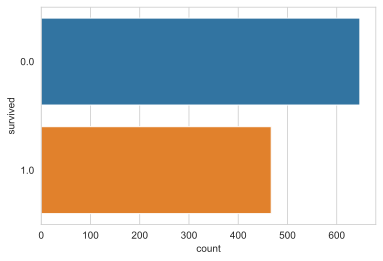

In [6]:
sns.countplot(data=df, y='survived')
plt.show()

Классы не сбалансированы. PR кривая

#### 4.Выполните масштабирование количественных признаков. Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования.

In [7]:
def cast(obj):
    if type(obj) == str:
        return float(obj.replace(',', '.'))
    else:
        return obj
df['age'] = df['age'].apply(lambda x: cast(x))
df['fare'] = df['fare'].apply(lambda x: cast(x))
df['pclass'] = df['pclass'].apply(lambda x: str(x))

#категориальные и числовые признаки
num_col = [i for i in df.columns if df[i].dtype.name != 'object']
cat_col = [i for i in df.columns if df[i].dtype.name == 'object']
print('num: ', num_col)
print('cat: ', cat_col)

num:  ['survived', 'age', 'sibsp', 'parch', 'fare']
cat:  ['pclass', 'sex', 'embarked']


In [8]:
# заполним пропущенные значения параметра age медианными, избежать потери данных при очистке NaN
df['age'] = df['age'].fillna(df['age'].median())
df = df.dropna().reset_index(drop=True)
print('ds', df.shape)
df.count()

ds (1111, 8)


pclass      1111
survived    1111
sex         1111
age         1111
sibsp       1111
parch       1111
fare        1111
embarked    1111
dtype: int64

In [9]:
# нормализуем
scaler = MinMaxScaler()
df[num_col] = scaler.fit_transform(df[num_col])
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1.0,female,0.361169,0.000,0.000000,0.412503,S
1,1.0,1.0,male,0.009395,0.125,0.222222,0.295806,S
2,1.0,0.0,female,0.022964,0.125,0.222222,0.295806,S
3,1.0,0.0,male,0.373695,0.125,0.222222,0.295806,S
4,1.0,0.0,female,0.311064,0.125,0.222222,0.295806,S


#### 5.Выполните замену категориальных признаков

In [12]:
# бинарные и небинарные признаки
binary_columns = [i for i in cat_col if len(df[i].unique()) == 2]
nonbinary_columns = [i for i in cat_col if len(df[i].unique()) > 2]

# для бинарных заменим на 1 и 0
for col in binary_columns:
    for i, unic_item in enumerate(df[col].unique()):
        df[col] = df[col].replace(to_replace=[unic_item], value=[i])
        
# для не бинарых dummy-кодирование
df_nonbinary = pd.get_dummies(df[nonbinary_columns])
df.drop(nonbinary_columns, axis=1, inplace=True)
df = pd.concat([df_nonbinary, df] , axis=1)

print(df.shape)
df.head()

(1111, 12)


,pclass_1.0,pclass_2.0,pclass_3.0,embarked_C,embarked_Q,embarked_S,survived,sex,age,sibsp,parch,fare
0,1,0,0,0,0,1,1.0,0,0.361169,0.000,0.000000,0.412503
1,1,0,0,0,0,1,1.0,1,0.009395,0.125,0.222222,0.295806
2,1,0,0,0,0,1,0.0,0,0.022964,0.125,0.222222,0.295806
3,1,0,0,0,0,1,0.0,1,0.373695,0.125,0.222222,0.295806
4,1,0,0,0,0,1,0.0,0,0.311064,0.125,0.222222,0.295806


#### 6.Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других 

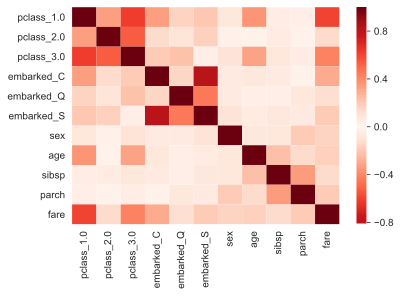

In [13]:
df_corr = df.drop('survived', axis=1).corr()
colors = sns.color_palette("Reds_r", n_colors=100)
colors += sns.color_palette("Reds", n_colors=100)
sns.heatmap(df_corr, cmap=colors, center=0)
plt.show()

##### 7. Заполните пропущенные значения в данных

In [14]:
print('ds', df.shape)
df.count()

ds (1111, 12)


pclass_1.0    1111
pclass_2.0    1111
pclass_3.0    1111
embarked_C    1111
embarked_Q    1111
embarked_S    1111
survived      1111
sex           1111
age           1111
sibsp         1111
parch         1111
fare          1111
dtype: int64

##### 8. Решите поставленную задачу классификации в соответствии с заданием.
##### классификатор K ближайших соседей
##### логический классификатор (бинарное решающее дерево)

In [15]:
# разделим на данные для обучения и теста
X, y = df.drop('survived', axis=1), df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

Ближайшие соседи - подбор параметров

In [16]:
knn = KNeighborsClassifier()
params = {'n_neighbors': list(range(1, 50))}
knn_grid = GridSearchCV(knn, params)
knn_grid.fit(X_train, y_train)
best_num = knn_grid.best_estimator_.n_neighbors
best_score = knn_grid.best_score_

print('the best train score: ', best_score,
      '\t at the neighbors number: ', best_num)

rnc = KNeighborsClassifier(n_neighbors=best_num)
rnc.fit(X_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(X_test))
print('the test score: ', best_score)

the best train score:  0.7825144747725392 	 at the neighbors number:  25
the test score:  0.7664670658682635


Решающее дерево - подбор параметров

In [18]:
dtc = DecisionTreeClassifier()

params = {'max_depth': list(range(1,12)), 'max_features': list(range(1,12))}

dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit(X_train, y_train)

best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print('the best train score:', best_score, 
      '\t at the features number:', best_features,
      '\t at the depth:', best_depth)

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(X_train, y_train)
best_score  = np.mean(y_test == dtc.predict(X_test))
print('the test score: ', best_score)

the best train score: 0.7825475599669147 	 at the features number: 11 	 at the depth: 5
the test score:  0.7844311377245509


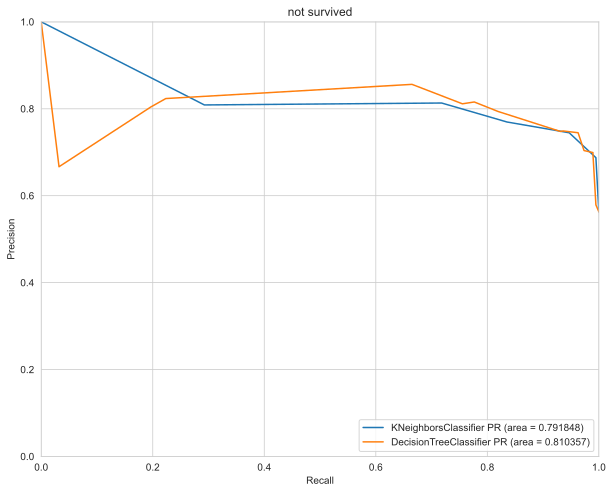

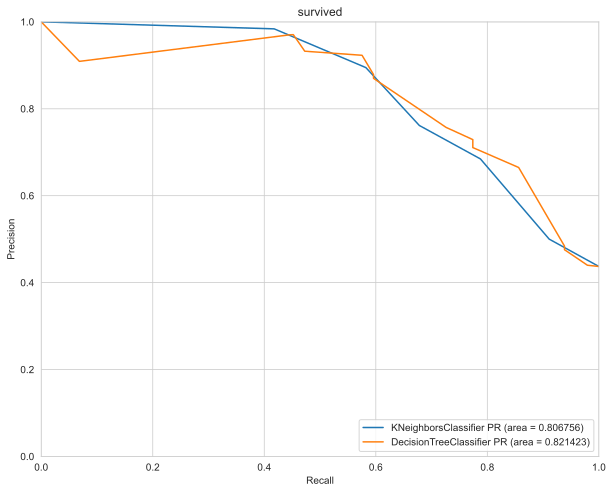

In [19]:
plt.figure(figsize=(10,8))
y_test_invers = []
for i, y in enumerate(y_test.reset_index(drop=True)):
    y_test_invers.append(1-y)
    
probas_knn0 = knn.fit(X_train, y_train).predict_proba (X_test)
probas_dtc0 = dtc.fit(X_train, y_train).predict_proba (X_test)
probas_knn1 = knn.fit(X_train, y_train).predict_proba (X_test)
probas_dtc1 = dtc.fit(X_train, y_train).predict_proba(X_test)
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_knn1[:,0])
aps_knn1 = average_precision_score(y_test_invers,probas_knn1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('KNeighborsClassifier', aps_knn1)) 
# Решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_dtc1[:,0])
aps_dtc1 = average_precision_score(y_test_invers,probas_dtc1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# График
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('not survived')
plt.show()


plt.figure(figsize=(10,8))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test, probas_knn0[:,1])
aps_knn0 = average_precision_score(y_test,probas_knn0[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('KNeighborsClassifier', aps_knn0)) 
# Решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test, probas_dtc1[:,1])
aps_dtc1 = average_precision_score(y_test,probas_dtc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# График
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('survived')
plt.show()

#### Вывод
Дерево принятия решений и k ближайших соседей имеют примерно одинаковые показатели качества относительно PR и ROC кривых. Можно сказать, что классификаторы правильно решают задачу предсказания класса с вероятностью 0.8~0.85, что является не слишком точным. Но все же далеко от случайного - 0.5. Поэтому можно сказать, что задача классификации была решена.